## Setup Environment

In [1]:
# start meshcat server
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=['--ngrok_http_tunnel'])

import numpy as np
from IPython.display import display, SVG, HTML
import pydot

import pydrake.all

from pydrake.all import (
    DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, le, 
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser, MathematicalProgram, eq, PiecewisePolynomial, SnoptSolver, Solve
)

from pydrake.systems.primitives import ConstantVectorSource
from pydrake.autodiffutils import AutoDiffXd
from pydrake.multibody.tree import MultibodyForces_
from pydrake.multibody.plant import MultibodyPlant_
from pydrake.symbolic import Expression

# Luxo Dynamics

Loaded from an `.urdf` file. 

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6004...
You can open the visualizer by visiting the following URL:
http://2809-35-171-17-88.ngrok.io/static/
Connected to meshcat-server.


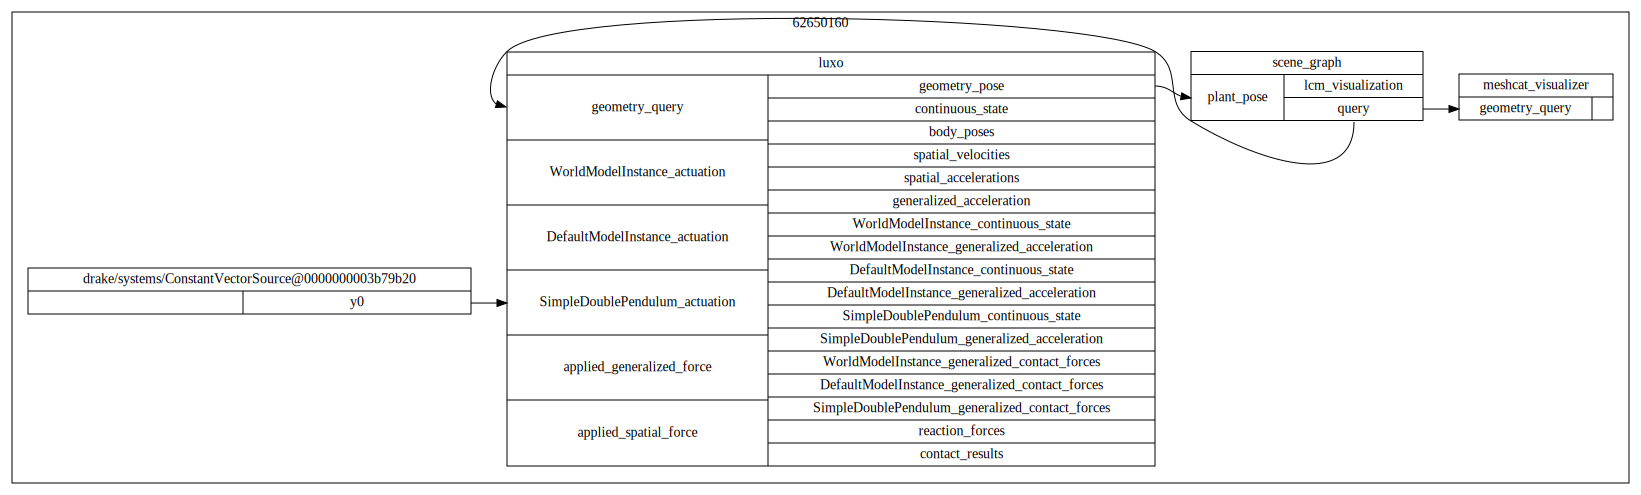

KeyboardInterrupt: 

In [13]:
builder = DiagramBuilder()
luxo, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
Parser(luxo).AddModelFromFile("luxo.urdf")
luxo.Finalize()
luxo.set_name('luxo')

# Setup visualization
visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
    builder, 
    scene_graph=scene_graph, 
    zmq_url=zmq_url)
#visualizer.vis.delete()
#visualizer.set_planar_viewpoint(xmin=-4, xmax=4, ymin=-4, ymax=4)

# Setup torque input
u = np.array([0,0])
torque_system = builder.AddSystem(ConstantVectorSource(u))
builder.Connect(torque_system.get_output_port(0), luxo.get_input_port(3))

diagram = builder.Build()

# For reference, let's draw the diagram we've assembled:
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# Set the initial conditions
context.SetContinuousState([0, 1, -2, 0, 0, 0]) # y, theta1, theta2, ydot, theta1dot, theta2dot?
context.SetTime(0.0)

simulator.set_target_realtime_rate(1.0)

while True:
    simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)



# Trajectory Optimization

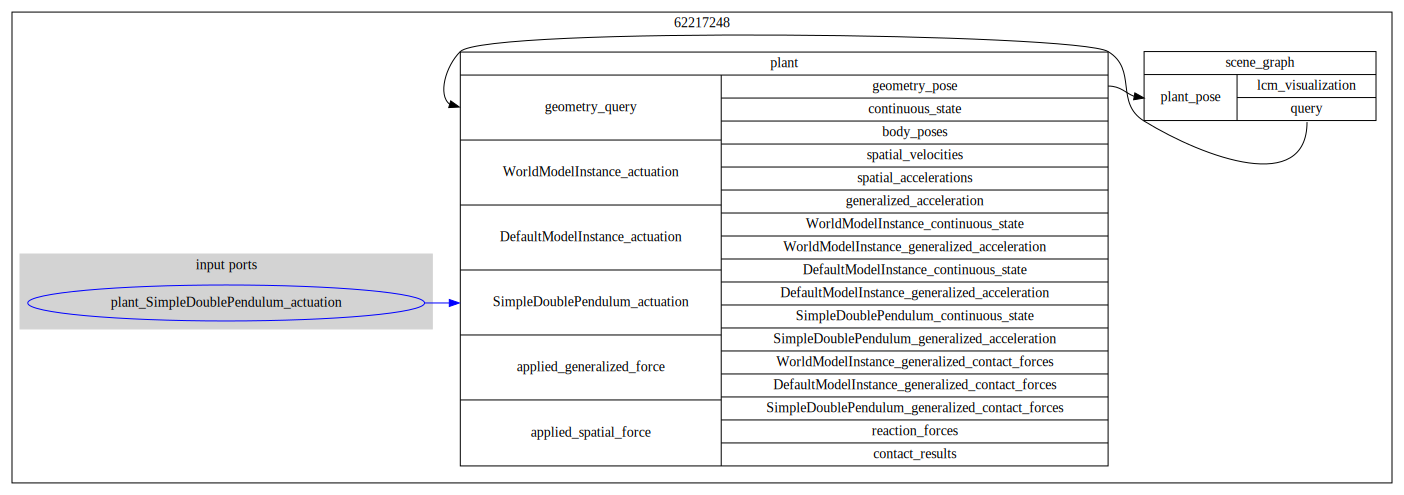

[Variable('x(0)', Continuous) Variable('x(1)', Continuous)
 Variable('x(2)', Continuous) Variable('x(3)', Continuous)
 Variable('x(4)', Continuous) Variable('x(5)', Continuous)]


AssertionError: 

In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (DiagramBuilder, DirectCollocation, MultibodyPlant,
                         MultibodyPositionToGeometryPose, Parser,
                         PiecewisePolynomial, PlanarSceneGraphVisualizer,
                         SceneGraph, Simulator, Solve, TrajectorySource,
                         AddMultibodyPlantSceneGraph, PassThrough, BasicVector)

builder = DiagramBuilder()

plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
Parser(plant).AddModelFromFile("luxo.urdf")
plant.Finalize()

builder.ExportInput(plant.get_input_port(3))
diagram = builder.Build()
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

context = diagram.CreateDefaultContext()
dircol = DirectCollocation(
    diagram,
    context,
    num_time_samples=21,
    minimum_timestep=0.1,
    maximum_timestep=0.4,
    input_port_index = diagram.get_input_port(0).get_index())

dircol.AddEqualTimeIntervalsConstraints()

initial_state = (0, 1, -2, 0, 0, 0) # y, theta1, theta2, ydot, theta1dot, theta2dot
dircol.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())

final_state = (0.5, 0, 0, 0, 0, 0) # y, theta1, theta2, ydot, theta1dot, theta2dot
#dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())


R = 10  # Cost on input "effort".
u = dircol.input()
x = dircol.state()
print(x)
dircol.AddRunningCost((R * u[0]**2) + x.dot(x))

# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert result.is_success()

fig, ax = plt.subplots()

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
u_values = u_lookup(times)

ax.plot(times, u_values)
ax.set_xlabel("time (seconds)")
ax.set_ylabel("force (Newtons)");

In [ ]:
# Animate the results.
from IPython.display import HTML
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend
plt_is_interactive = SetupMatplotlibBackend()

x_trajectory = dircol.ReconstructStateTrajectory(result)

# TODO(russt): Add some helper methods to make this workflow cleaner.
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_trajectory))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(
    MultibodyPositionToGeometryPose(plant, inpssssssssssssssut_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(),
                scene_graph.get_source_pose_port(plant.get_source_id()))

visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph,
                               xlim=[-2, 2],
                               ylim=[-1.25, 2],
                               show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

AdvanceToAndVisualize(simulator, visualizer, x_trajectory.end_time())

ModuleNotFoundError: No module named 'underactuated'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5fd8e1d3-71c2-47d4-871c-7eed4e2b387c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>